# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix 

In [14]:
num_classes = 10 
num_features = 784 

learning_rate = 0.0001 
training_steps = 10000 
batch_size = 256 
display_step = 100 

n_hidden_1 = 512
n_hidden_2 = 1024

In [15]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [16]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.batch_norm = tf.keras.layers.BatchNormalization()

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        y = self.batch_norm(y)  
        if activation == 0:
            return tf.nn.relu(y)
        else:
            return tf.nn.softmax(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.output_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x, activation=1)
        return x

In [17]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [18]:
neural_net = NN(name="mnist")

def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.Adam(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

Step: 100, Loss: 18.45665740966797, Accuracy: 0.109375
Step: 200, Loss: 19.0233097076416, Accuracy: 0.08203125
Step: 300, Loss: 18.942371368408203, Accuracy: 0.0859375
Step: 400, Loss: 18.537609100341797, Accuracy: 0.10546875
Step: 500, Loss: 18.861408233642578, Accuracy: 0.08984375
Step: 600, Loss: 18.699508666992188, Accuracy: 0.09765625
Step: 700, Loss: 18.21380615234375, Accuracy: 0.12109375
Step: 800, Loss: 18.375707626342773, Accuracy: 0.11328125
Step: 900, Loss: 18.942358016967773, Accuracy: 0.0859375
Step: 1000, Loss: 18.45665740966797, Accuracy: 0.109375
Step: 1100, Loss: 19.589962005615234, Accuracy: 0.0546875
Step: 1200, Loss: 17.566204071044922, Accuracy: 0.15234375
Step: 1300, Loss: 17.97097396850586, Accuracy: 0.1328125
Step: 1400, Loss: 17.485254287719727, Accuracy: 0.15625
Step: 1500, Loss: 16.918601989746094, Accuracy: 0.18359375
Step: 1600, Loss: 18.378028869628906, Accuracy: 0.1171875
Step: 1700, Loss: 17.161453247070312, Accuracy: 0.171875
Step: 1800, Loss: 18.53760

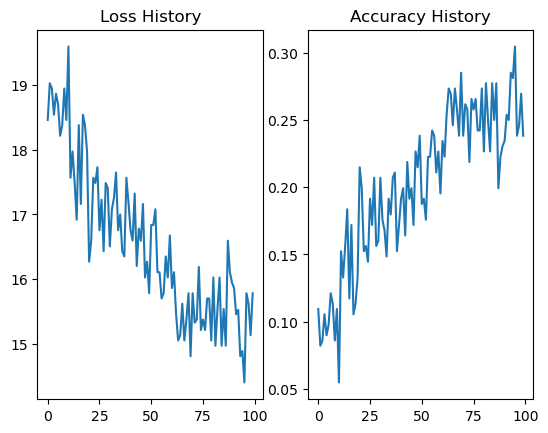

Test Accuracy: 0.267300009727478


In [19]:
loss_history = []  
accuracy_history = [] 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss History')
plt.title('Loss History')
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy History')
plt.title('Accuracy History')
plt.show()

pred = neural_net(x_test)
test_accuracy = accuracy(pred, y_test)
print(f"Test Accuracy: {test_accuracy}")

In [20]:
from sklearn.metrics import classification_report
y_pred = tf.argmax(neural_net(x_test), axis=1).numpy()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.30      0.85      0.45      1032
           3       0.24      0.86      0.37      1010
           4       0.28      0.94      0.43       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.14      0.00      0.00      1009

    accuracy                           0.27     10000
   macro avg       0.10      0.27      0.12     10000
weighted avg       0.10      0.27      0.13     10000



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
